In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import seaborn as sns
from utils import feature_list

data_path = '../data/'

#define some variables to be able to run it as a whole 
use_custom_font = True
save = True
show = False
load_big = False
gen_plots = False


x_train_opt_norm_path = f"{data_path}x_opt_small_train.npy"
y_train_opt_norm_path = f"{data_path}y_opt_small_train.npy"
x_test_opt_norm_path = f"{data_path}x_opt_small_test.npy"
y_test_opt_norm_path = f"{data_path}y_opt_small_test.npy"


def gen_hist(bg,sig,feature):
    
    hist_bg = np.histogram(bg[:,feature],bins = 30, density=True)
    hist_sig = np.histogram(sig[:,feature],bins = 30, density=True)

    plt.figure(figsize=(6,6), dpi=(100))
    plt.step(hist_bg[1][:-1],hist_bg[0], color = tuple(np.array([8,41,100,255])/ 255.))
    plt.step(hist_sig[1][:-1],hist_sig[0], color=tuple(np.array([200,20,8,255])/ 255.))

    plt.fill_between(hist_bg[1][:-1],hist_bg[0], np.zeros_like(hist_bg[0]), 
                    color = tuple(np.array([8,41,100,100])/ 255.), step = 'pre', label = 'Background')
    plt.fill_between(hist_sig[1][:-1],hist_sig[0], np.zeros_like(hist_sig[0]), 
                    color = tuple(np.array([200,20,8,50])/ 255.), step = 'pre', label = 'Signal')
    plt.legend()
    plt.ylabel('Density')
    plt.xlabel(feature_list[feature])

In [2]:
#uncomment for loading full data and saving it in a asmaller file
"""b = np.load(f"{data_path}y_data_optimal_norm_big_test.npy")
print(np.shape(b))

#bkg 4.4M x 67
#sig 1.1M x 67


np.save(f"{data_path}y_opt_small_test.npy",b[:100000])
b = []"""
print("")

In [3]:
x_train = np.load(x_train_opt_norm_path)
y_train = np.load(y_train_opt_norm_path)
x_test = np.load(x_test_opt_norm_path)
y_test = np.load(y_test_opt_norm_path)

bg_train = np.where(y_train == 0)
sig_train = np.where(y_train == 1)


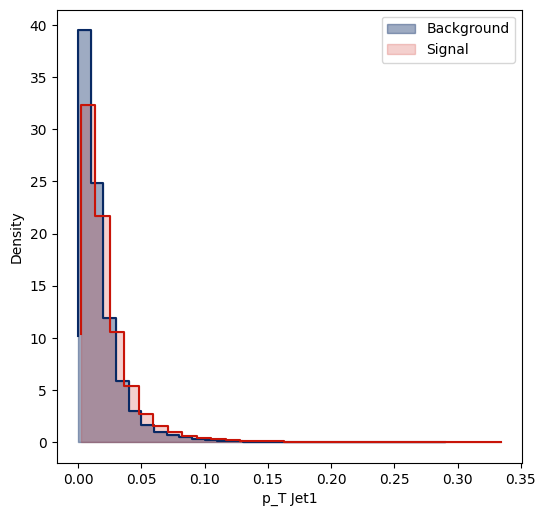

In [4]:
feature = 0


gen_hist(x_train[bg_train],x_train[sig_train], feature = 0)

In [5]:
from sklearn.decomposition import PCA, KernelPCA

n_c = 6
transformer = PCA(n_components= n_c)
transformer.fit(x_train)

x_tf_train = transformer.transform(x_train)
x_tf_test = transformer.transform(x_test)

from sklearn.kernel_approximation import Nystroem
feature_map = Nystroem(kernel='laplacian',gamma=0.2,n_components=8)
x_tf = feature_map.fit_transform(x_train, y_train)


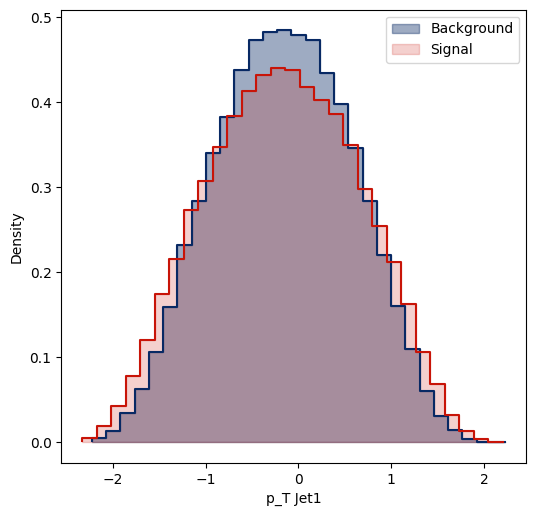

In [6]:
gen_hist(x_tf_train[bg_train],x_tf_train[sig_train], feature = 0)

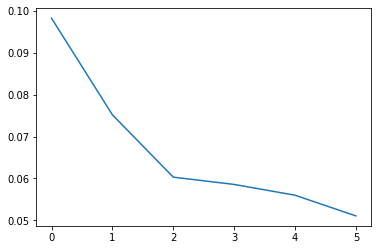

In [7]:
plt.plot(transformer.explained_variance_ratio_)
#gen_hist(x_tf_train[bg_train],x_tf_train[sig_train], feature = 0)

In [8]:
from sklearn.svm import SVC

svm = SVC(kernel = 'sigmoid')
svm.fit(x_tf_train[:10000], y_train[:10000])

SVC(kernel='sigmoid')

In [9]:
y_pred = svm.predict(x_tf_train[10000:12000])

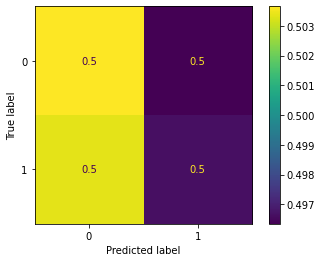

In [10]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train[10000:12000],y_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [49]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

from qiskit import BasicAer, Aer
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms import QSVC

seed = 12345
algorithm_globals.random_seed = seed

In [50]:
feature_map = PauliFeatureMap(feature_dimension=n_c, reps=5, entanglement = 'linear')

backend = QuantumInstance(
    BasicAer.get_backend("statevector_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
)

adhoc_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

In [51]:
svc = SVC( kernel=adhoc_kernel.evaluate, probability = True)
svc.fit(x_tf_train[:576], y_train[:576])


SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7ffaa94f0580>>,
    probability=True)

In [52]:
import pickle
pickle.dump(svc, open("svc100.sav","wb"))

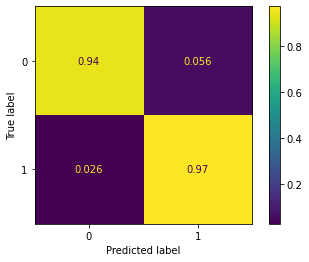

In [53]:
n_pred = 50
y_pred = svc.predict(x_tf_train[:576])
cm = confusion_matrix(y_train[:576],y_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()

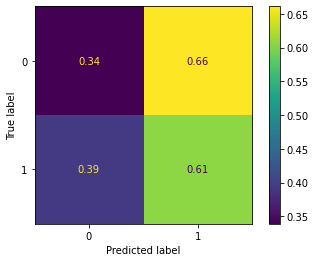

In [54]:
n_pred = 700
y_pred = svc.predict(x_tf_train[1000:1700])
cm = confusion_matrix(y_train[1000:1700],y_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [55]:
from sklearn.metrics import auc

y_prob = svc.predict_proba(x_tf_train[1000:1700])


In [57]:
from sklearn.metrics import roc_auc_score

a = roc_auc_score(y_train[1000:1700],y_prob[:,0])
print(a)

0.5014332263517651
